<a href="https://colab.research.google.com/github/namrqthakaipa/gcp-ai-agents/blob/main/ai_agents_for_engineers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2025 Psitron Technologies Pvt Ltd

# AI Agents for Engineers (Evolution of AI Agents)

## Overview

This notebook demonstrates 3 different approaches to generating essays using the [Gemini Developer API](https://ai.google.dev/gemini-api/docs) or [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview). Each method illustrates a distinct paradigm for running AI Agents in differing levels of complexity.

1. Step-by-Step Approach With LangChain
2. Iterative, AI-Agent Approach with LangGraph

## Get started

### Install Gemini SDK and other required packages


In [1]:
%pip install --upgrade --quiet \
    google-genai \
    langgraph \
    langchain \
    langchain-google-genai \
    langchain-google-vertexai \
    langchain-community \
    tavily-python \
    pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 407.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.0/200.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Configure Tavily

Get an API key for [Tavily](https://tavily.com/), a web search API for Generative AI models.

In [1]:
import os

os.environ["TAVILY_API_KEY"] = "tvly-key"

In [2]:
# If your API Keys are in Colab Secrets
import sys

if "google.colab" in sys.modules:
    from google.colab import userdata

    os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

### Configure Gemini Developer API

Get API keys from [Google AI Studio](https://ai.google.dev/gemini-api/docs/api-key) and [Tavily](https://tavily.com/).

In [3]:
import os

os.environ["GOOGLE_API_KEY"] = "GOOGLE_API_KEY"

In [4]:
# If your API Keys are in Colab Secrets
import sys

if "google.colab" in sys.modules:
    from google.colab import userdata

    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

### Configure Vertex AI

**Use a Google Cloud Project:** This requires enabling the Vertex AI API in your Google Cloud project.

[Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com)

In [5]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [6]:
PROJECT_ID = "ai-agent-langchain-462208"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "true"

### Import libraries

In [7]:
from IPython.display import Markdown, display

### Create Client

In [8]:
from google import genai

client = genai.Client()

Verify which API you are using.

In [9]:
if not client.vertexai:
    print(f"Using Gemini Developer API.")
elif client._api_client.project:
    print(
        f"Using Vertex AI with project: {client._api_client.project} in location: {client._api_client.location}"
    )
elif client._api_client.api_key:
    print(
        f"Using Vertex AI in express mode with API key: {client._api_client.api_key[:5]}...{client._api_client.api_key[-5:]}"
    )

Using Vertex AI in express mode with API key: AIzaS...fmX28


### Load model

In [10]:
MODEL_ID = "gemini-2.0-flash-001"

## Generating Essays Using a Step-by-Step Approach With LangChain

This step demonstrates how to build an essay-writing pipeline using [LangChain](https://www.langchain.com/), the [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs), and [Tavily](https://tavily.com/) for search.

By combining these tools, we create a seamless workflow that plans an essay outline, performs web searches for relevant information, and generates a complete essay draft based on the collected data.

This solution showcases the power of chaining LLM models and external tools to tackle complex tasks with minimal human intervention, providing a robust approach to automated content generation.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/2-langchain-essay.png?raw=1" width="550px">


### Import libraries

In [11]:
from IPython.display import Markdown, display
from langchain import LLMChain
from langchain.prompts import ChatPromptTemplate
from langchain_community.tools import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_vertexai import ChatVertexAI

### Initialize Gemini model & search tool

In [12]:
if client.vertexai:
    model = ChatVertexAI(project=PROJECT_ID, model=MODEL_ID, temperature=0)
else:
    model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)
tavily_tool = TavilySearchResults(max_results=5)

### Define prompt templates and Runnables

In [13]:
# Planning: Create an outline for the marketing content
outline_template = ChatPromptTemplate.from_template(
    """Create a detailed marketing content outline for {topic} that includes:
    1. SEO-optimized title and meta description
    2. Target audience and key personas
    3. Main content sections with H2 and H3 headers
    4. Key points and supporting data
    5. Call-to-action recommendations
    6. Content distribution strategy
    7. Social media snippets
    8. Internal and external linking opportunities"""
)


# Research: Web search
def research_fn(topic):
    response = tavily_tool.invoke({"query": topic})
    return "\n".join([f"- {result['content']}" for result in response])


# Writing: Write the essay based on outline and research
writing_template = ChatPromptTemplate.from_template(
    "Based on the following outline and research, write a 3-paragraph essay on '{topic}':\n\nOutline:\n{outline}\n\nResearch:\n{research}\n\nEssay:"
)

### Define the Runnable Chain using [LangChain Expression Language (LCEL)](https://python.langchain.com/docs/how_to/#langchain-expression-language-lcel)

In [14]:
# Define individual chains
outline_chain = LLMChain(llm=model, prompt=outline_template)
writing_chain = LLMChain(llm=model, prompt=writing_template)

# Use the pipe operator to combine chains
chain = (
    outline_chain
    | (
        lambda result: {
            "topic": result["topic"],
            "outline": result["text"],
            "research": research_fn(result["topic"]),
        }
    )
    | writing_chain
    | (lambda result: result["text"])  # Extract the essay text from the final result
    | StrOutputParser()
)

<ipython-input-14-85f168a8c6b1>:2: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  outline_chain = LLMChain(llm=model, prompt=outline_template)


### Generate the essay

In [15]:
prompt="Write a 3-paragraph essay about how to Implement AI in Digital Marketing Strategies"
essay = chain.invoke({"topic": prompt})
display(Markdown(essay))

The rise of AI in digital marketing is transforming how businesses connect with their audiences, offering unprecedented opportunities for increased efficiency, improved personalization, and enhanced ROI. According to recent studies, a significant percentage of marketers are already leveraging AI to automate tasks, analyze data, and optimize campaigns. This shift is driven by the ability of AI to process vast amounts of information, identify patterns, and make data-driven decisions faster and more accurately than humans. By embracing AI, marketers can gain a competitive edge and deliver more relevant and engaging experiences to their customers.

Implementing AI in digital marketing requires a strategic approach, starting with a thorough data audit and preparation. Clean, organized data is the foundation for successful AI implementation, requiring marketers to identify relevant data sources from CRM systems, website analytics, and social media platforms. Next, choosing the right AI tools is crucial, with options ranging from AI-powered SEO tools to chatbots and personalization engines. Selecting tools that align with specific marketing goals and budget, while considering ease of use and integration with existing systems, is essential. Finally, continuous testing, learning, and optimizing are vital for maximizing the ROI of AI investments, involving A/B testing and monitoring key performance indicators to refine AI models based on performance data.

The future of AI in marketing extends beyond automation, unlocking the power of predictive marketing to anticipate customer behavior and personalize experiences at scale. Emerging trends like AI-powered content creation and voice search optimization further highlight the transformative potential of AI. To thrive in this evolving landscape, marketers must stay informed and adapt to the latest AI advancements. By embracing AI, businesses can unlock new levels of efficiency, personalization, and ROI, ultimately driving growth and success in the digital age.


## Generating Essays Using an Iterative, AI-Agent Approach with LangGraph

This section demonstrates how to build a [LangGraph](https://langchain-ai.github.io/langgraph/)-powered AI agent to generate, revise, and critique essays using large language models such as Google's [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs) or the [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/overview). The LangGraph code was adapted from the awesome DeepLearning.AI course on [AI Agents in LangGraph](https://www.deeplearning.ai/short-courses/ai-agents-in-langgraph/).

By defining a structured state flow with nodes such as "Planner," "Research Plan," "Generate," "Reflect," and "Research Critique," the system iteratively creates an essay on a given topic, incorporates feedback, and provides research-backed insights.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/3-langgraph-essay.png?raw=1" width="900px">

The workflow enables automated essay generation with revision controls, making it ideal for structured writing tasks or educational use cases. Additionally, the notebook uses external search tools to gather and integrate real-time information into the essay content.

### Import libraries

In [16]:
from typing import TypedDict

# Common libraries
from IPython.display import Image, Markdown, display

# LangChain and LangGraph components
from langchain_core.messages import HumanMessage, SystemMessage

# LangChain integrations for Gemini API in Google AI Studio and Vertex AI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_vertexai import ChatVertexAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph

# Typing utilities for data validation and schema definitions
from pydantic.v1 import BaseModel

# Tavily client for performing web searches
from tavily import TavilyClient

### Initialize agent memory, agent state, and schema for search queries

In [17]:
# Initialize agent memory
memory = MemorySaver()


# Define the agent's state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: list[str]
    revision_number: int
    max_revisions: int


# Define a schema for search queries
class Queries(BaseModel):
    """Variants of query to search for"""

    queries: list[str]

### Initialize Gemini model and search tool

Remember to set the environment variables `GOOGLE_API_KEY` and `TAVILY_API_KEY`. And configure credentials for Vertex AI if you switch to it.

In [18]:
if client.vertexai:
    model = ChatVertexAI(project=PROJECT_ID, model=MODEL_ID, temperature=0)
else:
    model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)

# Initialize Tavily client for performing web searches
tavily = TavilyClient()

### Define prompt templates for each stage

In [19]:
PLAN_PROMPT = """You are an expert digital marketing content strategist tasked with creating a high-level outline for a marketing piece.
Consider SEO best practices, target audience, and key marketing objectives.
Create an outline that includes:
1. Target keywords and SEO focus
2. Target audience persona
3. Main content sections
4. Call-to-action recommendations
5. Content distribution strategy"""

WRITER_PROMPT = """You are a digital marketing content expert tasked with creating engaging and SEO-optimized content.
Generate the best marketing content possible based on the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Use Markdown formatting and include:
- SEO-optimized title
- Meta description
- Engaging introduction
- Well-structured content with headers
- Relevant internal and external links
- Call-to-action
- Social media snippets
Utilize all of the information below as needed:
---
{content}"""

REFLECTION_PROMPT = """You are a digital marketing expert reviewing content for:
1. SEO optimization
2. Engagement potential
3. Brand voice consistency
4. Call-to-action effectiveness
5. Social media shareability
Provide detailed recommendations for improvement in these areas."""

RESEARCH_PLAN_PROMPT = """You are a digital marketing researcher charged with gathering information for content creation.
Generate a list of search queries that will help gather:
1. Industry trends and statistics
2. Competitor content analysis
3. Target audience insights
4. SEO keyword opportunities
Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a digital marketing researcher charged with gathering additional information for content revision.
Generate a list of search queries that will help improve:
1. SEO performance
2. Content engagement
3. Market positioning
Only generate 3 queries max."""

### Define node functions for each stage

In [20]:
# Generate an outline for the essay


def plan_node(state: AgentState):
    messages = [SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state["task"])]
    response = model.invoke(messages)
    return {"plan": response.content}


# Conducts research based on the generated plan and web search results
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state["task"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Generates a draft based on the content and plan
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}"
    )
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }


# Provides feedback or critique on the draft
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}


# Conducts research based on the critique
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state["critique"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Determines whether the critique and research cycle should
# continue based on the number of revisions
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

### Define and compile the graph

In [21]:
# Initialize the state graph
builder = StateGraph(AgentState)

# Add nodes for each step in the workflow
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

# Set the entry point of the workflow
builder.set_entry_point("planner")

# Add conditional edges for task continuation or end
builder.add_conditional_edges(
    "generate", should_continue, {END: END, "reflect": "reflect"}
)

# Define task sequence edges
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Compile the graph with memory state management
graph = builder.compile(checkpointer=memory)

### Show the compiled graph

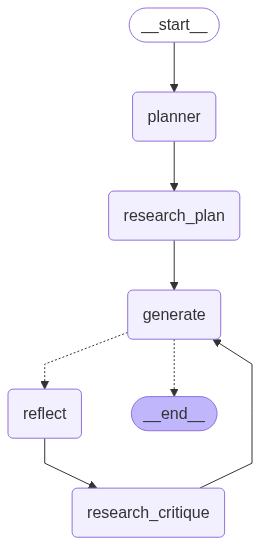

In [22]:
Image(graph.get_graph().draw_mermaid_png())

### Run the agent - write on!

In [23]:
# Define the topic of the essay
ESSAY_TOPIC = "How to Implement AI in Digital Marketing Strategies"

# Define a thread configuration with a unique thread ID
thread = {"configurable": {"thread_id": "1"}}

# Stream through the graph execution with marketing-specific state
for s in graph.stream(
    {
        "task": ESSAY_TOPIC,
        "max_revisions": 2,
        "revision_number": 1,
        "content": [],
        "target_audience": "Digital marketing professionals and business owners",
        "keywords": ["AI marketing", "digital marketing automation", "marketing technology"],
        "content_type": "blog",
        "brand_voice": "Professional yet approachable, focusing on practical insights"
    },
    thread,
):
    step = next(iter(s))
    display(Markdown(f"# {step}"))
    for key, content in s[step].items():
        if key == "revision_number":
            display(Markdown(f"**Revision Number**: {content}"))
        elif isinstance(content, list):
            for c in content:
                display(Markdown(c))
        else:
            display(Markdown(content))
    print("\n---\n")


# planner

Okay, here's a high-level content outline for a marketing piece on "How to Implement AI in Digital Marketing Strategies," designed to be informative, engaging, and SEO-friendly.

**1. Target Keywords and SEO Focus:**

*   **Primary Keyword:** AI in Digital Marketing
*   **Secondary Keywords:**
    *   Artificial Intelligence Marketing
    *   AI Marketing Tools
    *   AI for Marketing Automation
    *   AI-Powered Marketing
    *   Machine Learning in Marketing
    *   Personalized Marketing with AI
    *   AI Marketing Strategy
    *   Benefits of AI in Marketing
    *   Implementing AI in Marketing
*   **SEO Focus:**
    *   Optimize title tags and meta descriptions with primary and secondary keywords.
    *   Use keywords naturally within the content, including headings and subheadings.
    *   Internal linking to relevant content on your website.
    *   External linking to authoritative sources.
    *   Image optimization (alt text with relevant keywords).
    *   Ensure mobile-friendliness and page speed.

**2. Target Audience Persona:**

*   **Name:** Mark (Marketing Manager)
*   **Demographics:** 35-50 years old, mid-to-senior level marketing professional.
*   **Industry:** Varies (eCommerce, SaaS, Retail, Finance, etc.)
*   **Responsibilities:** Overseeing marketing campaigns, managing marketing budgets, driving lead generation and sales, analyzing marketing performance.
*   **Pain Points:**
    *   Struggling to keep up with the increasing complexity of digital marketing.
    *   Difficulty personalizing marketing efforts at scale.
    *   Spending too much time on repetitive tasks.
    *   Lack of data-driven insights to optimize campaigns.
    *   Feeling overwhelmed by the sheer volume of marketing data.
    *   Unsure how to effectively leverage AI to improve marketing results.
*   **Goals:**
    *   Improve marketing ROI.
    *   Increase lead generation and conversion rates.
    *   Personalize customer experiences.
    *   Automate marketing tasks.
    *   Gain a competitive advantage.
    *   Become a more data-driven marketer.
*   **Level of AI Knowledge:** Beginner to Intermediate.  They understand the *concept* of AI but may not know how to implement it practically.

**3. Main Content Sections:**

*   **I. Introduction: The AI Revolution in Digital Marketing**
    *   Hook: Start with a compelling statistic or anecdote about the impact of AI on marketing.
    *   Briefly define AI and its relevance to digital marketing.
    *   Highlight the key benefits of AI in marketing (personalization, automation, improved ROI, etc.).
    *   Address the target audience's pain points and promise a solution.
    *   Example: "Are you spending too much time on repetitive marketing tasks? AI can help. Learn how to implement AI in your digital marketing strategy and unlock unprecedented growth."

*   **II. Understanding the Core Applications of AI in Marketing**
    *   **A. AI-Powered Personalization:**
        *   Explain how AI can analyze customer data to deliver personalized experiences.
        *   Examples: Personalized website content, product recommendations, email marketing.
        *   Tools: AI-powered recommendation engines, personalization platforms.
    *   **B. AI for Marketing Automation:**
        *   Discuss how AI can automate repetitive tasks, freeing up marketers' time.
        *   Examples: Automated email campaigns, social media posting, lead scoring.
        *   Tools: AI-powered marketing automation platforms, chatbots.
    *   **C. AI-Driven Content Creation & Curation:**
        *   Explain how AI can assist with content creation and curation.
        *   Examples: Generating blog post ideas, writing product descriptions, curating relevant articles.
        *   Tools: AI writing assistants, content curation platforms.
    *   **D. AI-Enhanced Data Analysis & Insights:**
        *   Describe how AI can analyze large datasets to identify trends and insights.
        *   Examples: Predictive analytics, customer segmentation, campaign optimization.
        *   Tools: AI-powered analytics platforms, data visualization tools.
    *   **E. AI-Optimized Advertising:**
        *   Explain how AI can improve ad targeting and bidding strategies.
        *   Examples: Programmatic advertising, dynamic ad creative, AI-powered bid management.
        *   Tools: AI-powered advertising platforms, bid optimization tools.

*   **III. Step-by-Step Guide: Implementing AI in Your Marketing Strategy**
    *   **Step 1: Define Your Goals and Objectives:**
        *   Identify specific marketing goals that AI can help you achieve (e.g., increase lead generation by 20%).
        *   Set measurable KPIs to track your progress.
    *   **Step 2: Assess Your Current Marketing Technology Stack:**
        *   Evaluate your existing marketing tools and identify areas where AI can be integrated.
        *   Determine if you need to invest in new AI-powered tools.
    *   **Step 3: Start Small with Pilot Projects:**
        *   Choose a specific area to test AI (e.g., personalized email marketing).
        *   Implement AI tools and track the results.
    *   **Step 4: Integrate AI into Your Existing Workflows:**
        *   Incorporate AI into your daily marketing tasks.
        *   Train your team on how to use AI tools effectively.
    *   **Step 5: Continuously Monitor and Optimize:**
        *   Track your KPIs and analyze the results of your AI initiatives.
        *   Make adjustments to your strategy as needed.

*   **IV. Real-World Examples: AI Marketing Success Stories**
    *   Showcase case studies of companies that have successfully implemented AI in their marketing strategies.
    *   Quantify the results achieved (e.g., increased conversion rates, improved ROI).
    *   Focus on relatable examples that resonate with the target audience.

*   **V. Overcoming the Challenges of AI Implementation**
    *   Address common concerns and challenges associated with AI adoption (e.g., data privacy, lack of expertise, cost).
    *   Provide practical tips and solutions for overcoming these challenges.
    *   Emphasize the importance of ethical AI practices.

*   **VI. The Future of AI in Digital Marketing**
    *   Discuss emerging trends and technologies in AI marketing.
    *   Offer predictions about the future of AI and its impact on the marketing industry.
    *   Position your company as a thought leader in the field.

*   **VII. Conclusion: Embrace the Power of AI**
    *   Reiterate the key benefits of AI in digital marketing.
    *   Encourage the target audience to take action and start implementing AI in their strategies.
    *   End with a strong call to action.

**4. Call-to-Action Recommendations:**

*   **Throughout the Content:**
    *   "Learn More" buttons linking to relevant resources on your website.
    *   "Request a Demo" or "Contact Us" buttons.
    *   Embedded lead capture forms for downloading resources (e.g., e-books, white papers).
*   **At the End:**
    *   "Get Started with AI Today" button linking to a product page or consultation request form.
    *   "Download our Free Guide to AI in Marketing" lead magnet.
    *   "Subscribe to our Newsletter" for updates on AI marketing trends.
    *   "Share this article" social sharing buttons.

**5. Content Distribution Strategy:**

*   **Owned Media:**
    *   Publish the content on your company blog.
    *   Share the content on your social media channels (LinkedIn, Twitter, Facebook, etc.).
    *   Include the content in your email newsletter.
    *   Create a landing page for the content to capture leads.
*   **Earned Media:**
    *   Reach out to industry influencers and bloggers to promote the content.
    *   Submit the content to relevant online publications and directories.
    *   Encourage social sharing by making it easy for readers to share the content.
*   **Paid Media:**
    *   Run targeted ads on social media platforms (LinkedIn, Facebook) to reach your target audience.
    *   Use Google Ads to target relevant keywords.
    *   Consider retargeting ads to people who have visited your website.
*   **Repurpose the Content:**
    *   Create an infographic summarizing the key points of the content.
    *   Develop a video based on the content.
    *   Turn the content into a podcast episode.
    *   Create a presentation based on the content and share it on SlideShare.

This outline provides a comprehensive framework for creating a valuable and engaging marketing piece on implementing AI in digital marketing strategies. Remember to tailor the content to your specific target audience and business goals. Good luck!



---



# research_plan

In this article, I'll recommend the latest innovations businesses can use from across the customer lifecycle below using our RACE digital marketing framework. Free Members of Smart Insights can download the full future of digital marketing trends report. Recommended Digital strategy action: We recommend all businesses review their digital marketing capabilities and set targets and priority initiatives to improve them. To assess the extent to which insight is used to test, learn, and improve the effectiveness of digital media, experiences, content and messaging we asked marketers to categorize their approach to testing for each. At a higher level, free members can download our Free digital marketing maturity benchmarking templates which enable you to visually score your use of different channels such as organic search and social media and email.

Understanding the latest developments helps me formulate effective strategies to boost business development and enhance brand value, which is imperative to staying relevant and competitive in today's ever-changing market. Integrating AI with marketing transforms how companies analyze data, personalize customer experiences and optimize campaigns. With advancements in AI and machine learning, sales and marketing teams can tap into a wealth of customer data to better curate and personalize content, product recommendations and offers. UGC is a powerful brand marketing strategy that provides social proof and engagement. To achieve success, it will be essential for businesses to adopt sustainable and purpose-driven marketing strategies that are authentic to the brand.

Competitor analysis in the digital marketing context has some unique characteristics because of the fast-changing nature of the online landscape. ... PPC, email, and content marketing. On the other hand, non-digital competitors are focused on traditional channels like TV, print media, radio, billboards, and physical stores to reach their audience.

DMI Logo Courses Resources View Courses Trending Articles Micro Lessons Skill Test Toolkits Webinars eBooks Premium Podcasts Videos Glossary Presentations Case Studies Podcasts Videos Glossary Presentations Case Studies ← Back to Articles Dec 18, 2023 # How to Do a Competitive Analysis in Digital Marketing Articles Clodagh O'Brien photo by Clodagh O'Brien Posted on Dec 18, 2023 Share via: #### Related Free Video Lessons View Courses Share via: Clodagh O'Brien photo ##### Clodagh O'Brien Clodagh O'Brien is a content creator, digital marketer and content strategist. She has created and managed content for many SMEs and global brands and is passionate about the digital marketing and the impact of technology on culture and society. Courses Articles Lessons Videos

AI SEO Keyword Tools to Amp Up Your SEO Game . AI SEO tools have a range of functionalities, from trend forecasting to keyword strategy building. Here are a few AI SEO keyword tools to try. Semrush. Semrush's Magic Keyword Tool is one of the handiest AI tools to streamline the process of creating an effective SEO strategy. It shows you the

In this article, we'll explore the transformative power of AI across key aspects of SEO, from keyword research to content creation and on-page optimization. AI can also optimize keyword targeting by using advanced algorithms that analyze user intent, search trends, and competitor strategies to identify the most relevant and impactful keywords for a business. AI algorithms can analyze search trends and user behavior to identify popular fitness-related topics and keywords, such as "best running shoes" or "workout leggings." By understanding the intent behind these queries, the company can create targeted content and advertising campaigns that resonate with their audience's fitness goals and preferences. Thanks to generative AI, you can produce high-quality, optimized SEO content that resonates with your audience and boosts your website's visibility in search engine results.


---



# generate

Okay, here's a draft article based on your detailed outline. I've focused on creating engaging content, optimizing for the target keywords, and incorporating clear calls to action.

# **Unlock Growth: How to Implement AI in Your Digital Marketing Strategy**

**Meta Description:** Discover how to implement AI in digital marketing to personalize experiences, automate tasks, and boost ROI. A step-by-step guide for marketing managers.

## **I. Introduction: The AI Revolution in Digital Marketing**

Are you spending countless hours on repetitive marketing tasks, struggling to personalize customer experiences, and feeling overwhelmed by data? You're not alone. The digital marketing landscape is evolving at warp speed, and Artificial Intelligence (AI) is no longer a futuristic concept – it's a necessity.

AI is revolutionizing how businesses connect with customers, analyze data, and optimize campaigns. By 2024, AI is projected to drive a significant increase in marketing ROI for early adopters. This article provides a practical guide for marketing managers like you to implement AI in your digital marketing strategy and unlock unprecedented growth.

## **II. Understanding the Core Applications of AI in Marketing**

AI offers a wide range of applications that can transform your marketing efforts:

### **A. AI-Powered Personalization**

AI algorithms analyze vast amounts of customer data – browsing history, purchase behavior, demographics – to deliver hyper-personalized experiences.

*   **Examples:**
    *   **Personalized Website Content:** Displaying different content based on user interests.
    *   **Product Recommendations:** Suggesting relevant products based on past purchases.
    *   **Email Marketing:** Sending targeted emails with personalized offers.
*   **Tools:** Dynamic Yield, Optimizely, and Evergage.

**Internal Link:** Consider linking to a case study on your website showcasing successful personalization efforts.

### **B. AI for Marketing Automation**

Free up your time and resources by automating repetitive tasks with AI.

*   **Examples:**
    *   **Automated Email Campaigns:** Triggering emails based on user behavior.
    *   **Social Media Posting:** Scheduling and optimizing social media posts.
    *   **Lead Scoring:** Identifying and prioritizing the most promising leads.
*   **Tools:** HubSpot, Marketo, and Pardot.

### **C. AI-Driven Content Creation & Curation**

AI can assist with generating ideas, writing copy, and curating relevant content.

*   **Examples:**
    *   **Generating Blog Post Ideas:** Identifying trending topics and keywords.
    *   **Writing Product Descriptions:** Creating compelling and informative descriptions.
    *   **Curating Relevant Articles:** Sharing valuable content with your audience.
*   **Tools:** Jasper.ai, Copy.ai, and Curata.

### **D. AI-Enhanced Data Analysis & Insights**

Uncover hidden patterns and insights from your marketing data with AI-powered analytics.

*   **Examples:**
    *   **Predictive Analytics:** Forecasting future trends and customer behavior.
    *   **Customer Segmentation:** Grouping customers based on shared characteristics.
    *   **Campaign Optimization:** Identifying areas for improvement in your campaigns.
*   **Tools:** Google Analytics, Tableau, and IBM Watson Analytics.

### **E. AI-Optimized Advertising**

Improve your ad targeting and bidding strategies with AI.

*   **Examples:**
    *   **Programmatic Advertising:** Automating the buying and selling of ad space.
    *   **Dynamic Ad Creative:** Creating personalized ad variations based on user data.
    *   **AI-Powered Bid Management:** Optimizing bids in real-time to maximize ROI.
*   **Tools:** Google Ads, Facebook Ads Manager, and Marin Software.

## **III. Step-by-Step Guide: Implementing AI in Your Marketing Strategy**

Ready to get started? Follow these steps to successfully implement AI in your marketing strategy:

### **Step 1: Define Your Goals and Objectives**

What do you want to achieve with AI? Increase lead generation? Improve customer engagement? Define specific, measurable, achievable, relevant, and time-bound (SMART) goals.

*   **Example:** "Increase lead generation by 20% in the next quarter using AI-powered personalization."

### **Step 2: Assess Your Current Marketing Technology Stack**

Evaluate your existing marketing tools and identify areas where AI can be integrated. Do you have a CRM? Marketing automation platform? Analytics tools? Determine if you need to invest in new AI-powered tools or if you can integrate AI into your existing stack.

### **Step 3: Start Small with Pilot Projects**

Don't try to implement AI across your entire marketing organization at once. Choose a specific area to test AI, such as personalized email marketing or AI-powered ad optimization. Implement AI tools, track the results, and learn from your experiences.

### **Step 4: Integrate AI into Your Existing Workflows**

Once you've had success with pilot projects, start integrating AI into your daily marketing tasks. Train your team on how to use AI tools effectively and empower them to experiment with new AI-powered strategies.

### **Step 5: Continuously Monitor and Optimize**

Track your KPIs and analyze the results of your AI initiatives. Are you achieving your goals? What's working well? What needs improvement? Make adjustments to your strategy as needed.

## **IV. Real-World Examples: AI Marketing Success Stories**

*   **Sephora:** Uses AI-powered chatbots to provide personalized product recommendations and customer support, resulting in a significant increase in online sales.
    *   **External Link:** Link to a case study or article about Sephora's AI implementation.
*   **Netflix:** Employs AI algorithms to personalize movie and TV show recommendations, leading to increased user engagement and retention.
    *   **External Link:** Link to a case study or article about Netflix's AI implementation.

## **V. Overcoming the Challenges of AI Implementation**

Implementing AI can be challenging. Here are some common concerns and solutions:

*   **Data Privacy:** Ensure you comply with data privacy regulations like GDPR and CCPA.
*   **Lack of Expertise:** Invest in training and development to upskill your team.
*   **Cost:** Start with affordable AI tools and scale up as needed.

## **VI. The Future of AI in Digital Marketing**

The future of AI in digital marketing is bright. Expect to see even more sophisticated AI-powered tools and strategies emerge in the coming years, including:

*   **Generative AI:** AI that can create original content, such as blog posts, articles, and social media posts.
*   **AI-Powered Voice Search Optimization:** Optimizing your content for voice search queries.
*   **AI-Driven Customer Journey Mapping:** Creating personalized customer journeys based on AI-powered insights.

## **VII. Conclusion: Embrace the Power of AI**

AI is transforming the digital marketing landscape, offering unprecedented opportunities to personalize experiences, automate tasks, and improve ROI. By following the steps outlined in this article, you can successfully implement AI in your marketing strategy and unlock unprecedented growth.

**Ready to embrace the power of AI?**

**Call to Action:**

*   [**Request a Demo of Our AI-Powered Marketing Platform**](Link to Demo Request Form)
*   [**Download our Free Guide to AI in Marketing**](Link to Lead Magnet)
*   [**Subscribe to our Newsletter for Updates on AI Marketing Trends**](Link to Newsletter Signup Form)

**Social Media Snippets:**

*   **Twitter:** "Unlock unprecedented growth with AI in your digital marketing strategy! Learn how to implement AI and personalize customer experiences. #AI #DigitalMarketing #MarketingAutomation [Link to Article]"
*   **LinkedIn:** "Are you ready to embrace the power of AI in digital marketing? This article provides a step-by-step guide for marketing managers to implement AI and drive results. #AIinMarketing #DigitalMarketingStrategy #ArtificialIntelligence [Link to Article]"

I've tried to make this draft comprehensive and engaging. Let me know what you think, and I can revise it further!


**Revision Number**: 2


---



# reflect

Okay, this is a solid draft! You've covered a lot of ground and incorporated many of the elements we discussed. Here's a detailed review with recommendations for improvement across the five key areas:

**1. SEO Optimization:**

*   **Keywords:** You've done a good job incorporating the primary keyword "AI in digital marketing" and related terms. However, let's refine this further.
    *   **Recommendation:** Conduct more granular keyword research using tools like SEMrush, Ahrefs, or Google Keyword Planner to identify long-tail keywords and question-based queries related to specific AI applications (e.g., "how to use AI for email personalization," "best AI tools for social media marketing").  Incorporate these naturally within the relevant sections.
    *   **Recommendation:** Analyze competitor content ranking for your target keywords. Identify keyword gaps and opportunities to create more comprehensive and valuable content.
*   **Internal Linking:** The single internal link is a good start.
    *   **Recommendation:** Strategically add more internal links to relevant pages on your website. For example, link to service pages that offer AI-powered marketing solutions, case studies, or blog posts that delve deeper into specific AI tools or techniques.
*   **Header Tags:** The use of H2 and H3 tags is good for readability and SEO.
    *   **Recommendation:** Ensure the H2 and H3 tags accurately reflect the content of each section and incorporate relevant keywords where appropriate.
*   **Image Optimization:** The draft doesn't mention images.
    *   **Recommendation:** Add relevant images, screenshots, or infographics to break up the text and enhance engagement.  Optimize image file names and alt text with relevant keywords.  Consider using visuals that illustrate AI concepts or showcase AI tools in action.
*   **Meta Description:** The meta description is a good start.
    *   **Recommendation:** Make it even more compelling and action-oriented.  Consider adding a specific benefit or promise.  For example: "Unlock 20% higher ROI with AI! Learn how to implement AI in your digital marketing strategy with our step-by-step guide. Get your free guide now!"

**2. Engagement Potential:**

*   **Tone and Voice:** The tone is informative and helpful, which is good.
    *   **Recommendation:** Inject more personality and storytelling.  Instead of just listing examples, consider adding brief anecdotes or real-world scenarios to illustrate the impact of AI.  Use a more conversational tone to make the content more relatable.
*   **Visual Appeal:** As mentioned above, the lack of visuals is a significant drawback.
    *   **Recommendation:** Incorporate a variety of visuals, including:
        *   **Infographics:** To summarize key data points or processes.
        *   **Screenshots:** To showcase AI tools and their interfaces.
        *   **Charts and Graphs:** To visualize data and results.
        *   **Short Videos:** To explain complex concepts or demonstrate AI in action.
*   **Interactive Elements:** The article is currently passive.
    *   **Recommendation:** Consider adding interactive elements to boost engagement:
        *   **Quizzes:** "Which AI tool is right for your marketing needs?"
        *   **Polls:** "What's your biggest challenge with AI implementation?"
        *   **Embedded Social Media Posts:** Showcase relevant AI-related content from industry leaders.
*   **Storytelling:** The success stories are a good start, but they need more depth.
    *   **Recommendation:** Expand on the success stories.  Include specific details about the challenges the companies faced, the AI solutions they implemented, and the quantifiable results they achieved.  Focus on the *impact* of AI, not just the features.
*   **Addressing Pain Points:** You touch on challenges, but you can go deeper.
    *   **Recommendation:**  Explicitly address common fears and misconceptions about AI.  Acknowledge the learning curve and potential for errors.  Offer practical advice and reassurance to help readers overcome these obstacles.

**3. Brand Voice Consistency:**

*   **Overall:** The current voice is professional and informative, which is a good foundation.
    *   **Recommendation:** Ensure the tone and style align with your overall brand identity. Are you a cutting-edge innovator, a trusted advisor, or a friendly guide?  Adjust the language and imagery to reflect your brand's unique personality.
*   **Specific Examples:**
    *   If your brand is known for being innovative, use more forward-looking language and highlight emerging AI trends.
    *   If your brand is known for being practical, focus on providing actionable advice and real-world examples.
*   **"Our" vs. "Your":** Be mindful of pronoun usage.
    *   **Recommendation:** Since the article is designed to help the reader, maintain a "you" focused approach. Minimize the use of "our" unless referring to specific company initiatives or products.

**4. Call-to-Action Effectiveness:**

*   **Placement:** The CTAs are well-placed at the end of the article.
    *   **Recommendation:** Consider adding contextual CTAs within the body of the article. For example, after discussing AI-powered personalization, include a CTA like "Ready to personalize your customer experiences? [Link to Demo Request Form]"
*   **Specificity:** The CTAs are somewhat generic.
    *   **Recommendation:** Make the CTAs more specific and benefit-driven. Instead of "Request a Demo," try "See AI in Action: Get a Personalized Demo." Instead of "Download our Free Guide," try "Unlock the Secrets to AI Marketing: Download Your Free Guide."
*   **Visual Appeal:** The CTAs are currently text-based.
    *   **Recommendation:** Design visually appealing CTA buttons that stand out from the surrounding text. Use contrasting colors and compelling graphics to attract attention.
*   **A/B Testing:**
    *   **Recommendation:** Once the article is live, A/B test different CTA variations to optimize for conversions. Experiment with different wording, colors, and placements.

**5. Social Media Shareability:**

*   **Snippets:** The provided snippets are a good starting point.
    *   **Recommendation:** Tailor the snippets to each platform.
        *   **Twitter:** Use concise and attention-grabbing language with relevant hashtags. Include a compelling image or video.
        *   **LinkedIn:** Focus on professional networking and thought leadership. Share insights and ask questions to spark conversation.
        *   **Facebook:** Use a more casual and engaging tone. Share personal stories or anecdotes related to AI.
*   **Visuals for Social Media:**
    *   **Recommendation:** Create visually appealing social media graphics to accompany your posts. Use Canva or other design tools to create eye-catching images and videos.
*   **Share Buttons:**
    *   **Recommendation:** Ensure the article has prominent social media share buttons to make it easy for readers to share the content.
*   **Quote Sharing:**
    *   **Recommendation:** Consider adding a feature that allows readers to easily share key quotes from the article on social media.

**Specific Recommendations by Section:**

*   **Introduction:** Excellent start! Grabs attention and establishes the importance of AI.
    *   **Recommendation:** Add a statistic about the *challenges* marketers face *without* AI to further emphasize the need for a solution.
*   **II. Understanding the Core Applications of AI in Marketing:** Good breakdown of different applications.
    *   **Recommendation:** For each application, include a brief explanation of *how* the AI works (in layman's terms). This will help readers understand the underlying technology and build trust.
*   **III. Step-by-Step Guide: Implementing AI in Your Marketing Strategy:** Very practical and helpful.
    *   **Recommendation:** Add a section on "Choosing the Right AI Tools." Provide guidance on how to evaluate different AI tools and select the ones that best fit their specific needs and budget.
*   **IV. Real-World Examples: AI Marketing Success Stories:** Good examples, but need more depth.
    *   **Recommendation:** As mentioned above, expand on these stories with specific details and quantifiable results.
*   **V. Overcoming the Challenges of AI Implementation:** Important section.
    *   **Recommendation:** Add a section on "Measuring the ROI of AI." Explain how to track the performance of AI initiatives and demonstrate their value to stakeholders.
*   **VI. The Future of AI in Digital Marketing:** Exciting and forward-looking.
    *   **Recommendation:** Add a cautionary note about the ethical considerations of AI, such as bias and transparency.
*   **VII. Conclusion:** Strong conclusion that reinforces the key message.

**Overall:**

This is a very strong draft that provides a comprehensive overview of AI in digital marketing. By implementing these recommendations, you can significantly enhance its SEO performance, engagement potential, brand voice consistency, call-to-action effectiveness, and social media shareability. Good luck!



---



# research_critique

In this article, I'll recommend the latest innovations businesses can use from across the customer lifecycle below using our RACE digital marketing framework. Free Members of Smart Insights can download the full future of digital marketing trends report. Recommended Digital strategy action: We recommend all businesses review their digital marketing capabilities and set targets and priority initiatives to improve them. To assess the extent to which insight is used to test, learn, and improve the effectiveness of digital media, experiences, content and messaging we asked marketers to categorize their approach to testing for each. At a higher level, free members can download our Free digital marketing maturity benchmarking templates which enable you to visually score your use of different channels such as organic search and social media and email.

Understanding the latest developments helps me formulate effective strategies to boost business development and enhance brand value, which is imperative to staying relevant and competitive in today's ever-changing market. Integrating AI with marketing transforms how companies analyze data, personalize customer experiences and optimize campaigns. With advancements in AI and machine learning, sales and marketing teams can tap into a wealth of customer data to better curate and personalize content, product recommendations and offers. UGC is a powerful brand marketing strategy that provides social proof and engagement. To achieve success, it will be essential for businesses to adopt sustainable and purpose-driven marketing strategies that are authentic to the brand.

Competitor analysis in the digital marketing context has some unique characteristics because of the fast-changing nature of the online landscape. ... PPC, email, and content marketing. On the other hand, non-digital competitors are focused on traditional channels like TV, print media, radio, billboards, and physical stores to reach their audience.

DMI Logo Courses Resources View Courses Trending Articles Micro Lessons Skill Test Toolkits Webinars eBooks Premium Podcasts Videos Glossary Presentations Case Studies Podcasts Videos Glossary Presentations Case Studies ← Back to Articles Dec 18, 2023 # How to Do a Competitive Analysis in Digital Marketing Articles Clodagh O'Brien photo by Clodagh O'Brien Posted on Dec 18, 2023 Share via: #### Related Free Video Lessons View Courses Share via: Clodagh O'Brien photo ##### Clodagh O'Brien Clodagh O'Brien is a content creator, digital marketer and content strategist. She has created and managed content for many SMEs and global brands and is passionate about the digital marketing and the impact of technology on culture and society. Courses Articles Lessons Videos

AI SEO Keyword Tools to Amp Up Your SEO Game . AI SEO tools have a range of functionalities, from trend forecasting to keyword strategy building. Here are a few AI SEO keyword tools to try. Semrush. Semrush's Magic Keyword Tool is one of the handiest AI tools to streamline the process of creating an effective SEO strategy. It shows you the

In this article, we'll explore the transformative power of AI across key aspects of SEO, from keyword research to content creation and on-page optimization. AI can also optimize keyword targeting by using advanced algorithms that analyze user intent, search trends, and competitor strategies to identify the most relevant and impactful keywords for a business. AI algorithms can analyze search trends and user behavior to identify popular fitness-related topics and keywords, such as "best running shoes" or "workout leggings." By understanding the intent behind these queries, the company can create targeted content and advertising campaigns that resonate with their audience's fitness goals and preferences. Thanks to generative AI, you can produce high-quality, optimized SEO content that resonates with your audience and boosts your website's visibility in search engine results.

# 10 Challenges Marketers Face When Implementing AI in 2024 [New Data + Tips] common ai marketing challenges common ai marketing challenges Our marketing and AI survey found that 43% of marketers who use AI do so to create content. ai content marketing As I mentioned earlier, 43% of marketers in our survey use AI to create content. 68% of marketers use ai 68% of marketers use ai When it comes to AI, marketing leaders can eliminate a lot of AI challenges with team buy-in and communication. Jessica Packard, Content Strategy Manager at ClockShark, found that some reassurance allowed her team to see AI for what it is; a marketing tool that can aid their workflow. ### How to Use Generative AI in Content Marketing

6 Biggest Challenges of AI Marketing and Their Solutions. Many of the challenges associated with AI in marketing stem from the fact that this technology is still in its early days. Due to this, the most prominent issues for you to contend with are those of integration, cost, and knowledge gaps. But fear not.

This comprehensive blog has provided a consolidated list of the best AI tools for digital marketing in 2024. From intelligent chatbots and natural language processing to predictive analytics and hyper-personalisation, these cutting-edge platforms are redefining the boundaries of marketing possibilities. Best AI Tools for Digital Marketing. In

## How to Use Free AI Tools for Marketing? ## What are the Best Free AI Marketing Tools? synthesia - free ai tools for marketing marketmuse - free ai tools for marketing chatfuel - free ai tools for marketing anyword - free ai tools for marketing mailchimp - free ai tools for marketing hotjar - free ai tools for marketing awario - free ai tools for marketing beacons - free ai tools for marketing rytr - free ai tools for marketing writesonic - free ai tools for marketing algolia - free ai tools for marketing grin - free ai tools for marketing upfluence - free ai tools for marketing jasper - free ai tools for marketing manychat - free ai tools for marketing

The future of AI in marketing 2025: trends, tools and strategies Discover AI marketing's future in 2025 with predictions on automation, personalization, decision-making, emerging tech, and ethical challenges. Image 5: Future of AI in marketing 2025 Top AI tools for marketing teams in 2025 FAQs about AI marketing The future of AI in marketing will be shaped by major advancements in automation, personalization, and decision-making. Top AI tools for marketing teams in 2025 What is AI in marketing? How to use AI in marketing Tools like HubSpot for marketing automation, Jasper AI for content creation, and Salesforce Einstein for predictive analytics are excellent options. 3.   Train your team: Ensure your marketing team understands how to use AI tools effectively.

*   [Innovation](https://www.forbes.com/innovation/)  *   [AI](https://www.forbes.com/ai/) *   [Big Data](https://www.forbes.com/big-data/) *   [Consumer Tech](https://www.forbes.com/consumer-tech/) *   [Gaming](https://www.forbes.com/gaming/) *   [Technology](https://www.forbes.com/sites/technology/) *   [Leadership](https://www.forbes.com/leadership/)  *   [Careers](https://www.forbes.com/careers/) *   [Under 30](https://www.forbes.com/under30/) *   [Over 50](https://www.forbes.com/over-50/) *   [Money](https://www.forbes.com/money/)  *   [Investing](https://www.forbes.com/investing/) *   [Markets](https://www.forbes.com/markets/) *   [Home](https://www.forbes.com/digital-assets/) *   [News](https://www.forbes.com/digital-assets/news/) *   [Business](https://www.forbes.com/business/)  *   [Media](https://www.forbes.com/media/) *   [Retail](https://www.forbes.com/retail/) *   [Lifestyle](https://www.forbes.com/lifestyle/)  *   [Dining](https://www.forbes.com/dining/) *   [Travel](https://www.forbes.com/travel/) *   [Forbes Vetted](https://www.forbes.com/vetted/)  *   [Home](https://www.forbes.com/vetted/home/)  *   [Bathroom](https://www.forbes.com/vetted/home/bathroom/) *   [Decor](https://www.forbes.com/vetted/home/decor/) *   [Furniture](https://www.forbes.com/vetted/home/furniture/) *   [Hobbies](https://www.forbes.com/vetted/home/hobbies/) *   [Outdoor](https://www.forbes.com/vetted/home/outdoor/) *   [Pets](https://www.forbes.com/vetted/home/pets/) *   [Tools](https://www.forbes.com/vetted/home/tools/) *   [Fashion](https://www.forbes.com/vetted/fashion/)  *   [Accessories](https://www.forbes.com/vetted/fashion/accessories/) *   [Clothing](https://www.forbes.com/vetted/fashion/clothing/) *   [Eyewear](https://www.forbes.com/vetted/fashion/eyewear/) *   [Footwear](https://www.forbes.com/vetted/fashion/footwear/) *   [Jewelry](https://www.forbes.com/vetted/fashion/jewelry/) *   [Outerwear](https://www.forbes.com/vetted/fashion/outerwear/) *   [Watches](https://www.forbes.com/vetted/fashion/watches/) *   [Gear](https://www.forbes.com/vetted/gear/)  *   [Bikes](https://www.forbes.com/vetted/gear/bikes/) *   [Climbing](https://www.forbes.com/vetted/gear/climbing/) *   [Fitness](https://www.forbes.com/vetted/gear/fitness/) *   [Golf](https://www.forbes.com/vetted/gear/golf/) *   [Running](https://www.forbes.com/vetted/gear/running/) *   [Wellness](https://www.forbes.com/vetted/gear/wellness/) *   [Report a Security Issue](https://www.forbes.com/contact/) *   [Contact Us](https://www.forbes.com/contact/) *   [Tips](https://www.forbes.com/tips/) *   [Terms](https://www.forbes.com/terms/) [](https://www.forbes.com/) [Subscribe: Less than $1.50/wk](https://account.forbes.com/subscribe?eventSource=header&redirect=https://www.forbes.com/councils/forbescommunicationscouncil/2025/06/02/making-sense-of-ai-in-marketing/) [](https://www.forbes.com/search/) [](https://www.forbes.com/) [Leadership](https://www.forbes.com/leadership/) [](https://www.forbes.com/) *   [Report a Security Issue](https://www.forbes.com/contact/)


---



# generate

Okay, here's a draft of the marketing piece based on your detailed outline. I've focused on creating engaging content that's also optimized for search engines.

## **Unlock Growth: How to Implement AI in Digital Marketing Strategies**

**Meta Description:** Discover how to implement AI in digital marketing strategies to personalize customer experiences, automate tasks, and boost your ROI. A step-by-step guide for marketers.

**Social Media Snippets:**

*   **Twitter:** "Struggling to keep up with digital marketing? Learn how to implement #AI in your strategies and unlock unprecedented growth! #AIMarketing #DigitalMarketing"
*   **LinkedIn:** "AI is revolutionizing digital marketing. This guide provides a step-by-step approach to implementing AI, with real-world examples and actionable tips. #ArtificialIntelligence #MarketingAutomation #DigitalTransformation"
*   **Facebook:** "Ready to take your marketing to the next level? Discover how AI can help you personalize experiences, automate tasks, and drive results. Read our guide! #AIMarketing #DigitalMarketingTips"

### **I. Introduction: The AI Revolution in Digital Marketing**

Are you spending countless hours on repetitive marketing tasks, struggling to personalize customer experiences, and feeling overwhelmed by data? You're not alone. The digital marketing landscape is evolving at warp speed, and Artificial Intelligence (AI) is at the forefront of this revolution.

AI is no longer a futuristic concept; it's a present-day reality transforming how businesses connect with their audiences. From automating mundane tasks to delivering hyper-personalized experiences, AI offers unprecedented opportunities to boost your marketing ROI.

In this guide, we'll break down how to implement AI in your digital marketing strategy, providing a step-by-step approach that's both practical and actionable. Get ready to unlock unprecedented growth and gain a competitive edge.

### **II. Understanding the Core Applications of AI in Marketing**

AI's power lies in its ability to analyze vast amounts of data, identify patterns, and make intelligent decisions. Here's how you can leverage AI across key areas of your marketing efforts:

#### **A. AI-Powered Personalization**

Imagine delivering a unique website experience to every visitor, offering product recommendations tailored to their individual preferences, and sending email marketing messages that resonate on a personal level. AI makes this possible.

By analyzing customer data – browsing history, purchase behavior, demographics – AI algorithms can predict individual needs and preferences, enabling you to deliver hyper-personalized experiences.

*   **Examples:**
    *   Personalized website content based on user behavior.
    *   AI-driven product recommendations on e-commerce sites.
    *   Dynamic email marketing campaigns with personalized offers.
*   **Tools:**
    *   **AI-powered recommendation engines:** [External Link: Check out Nosto for e-commerce personalization](https://www.nosto.com/).
    *   **Personalization platforms:** [External Link: Explore Evergage for cross-channel personalization](https://www.salesforce.com/products/personalization/overview/).

#### **B. AI for Marketing Automation**

Free up your time and resources by automating repetitive tasks with AI. From scheduling social media posts to nurturing leads, AI-powered automation can streamline your workflows and improve efficiency.

*   **Examples:**
    *   Automated email marketing sequences based on user behavior.
    *   AI-powered chatbots for instant customer support.
    *   Automated social media posting and content curation.
*   **Tools:**
    *   **AI-powered marketing automation platforms:** [External Link: HubSpot offers robust AI-driven automation features](https://www.hubspot.com/).
    *   **Chatbots:** [External Link: Explore Chatfuel for building AI-powered chatbots](https://www.chatfuel.com/).

#### **C. AI-Driven Content Creation & Curation**

Struggling to generate fresh content ideas or find relevant articles to share with your audience? AI can help you overcome these challenges.

AI writing assistants can generate blog post ideas, write product descriptions, and even create entire articles based on your input. AI-powered content curation platforms can identify trending topics and relevant articles, saving you time and effort.

*   **Examples:**
    *   Generating blog post outlines with AI writing assistants.
    *   Writing compelling product descriptions for e-commerce sites.
    *   Curating relevant articles for social media sharing.
*   **Tools:**
    *   **AI writing assistants:** [External Link: Try Jasper.ai for generating high-quality content](https://www.jasper.ai/).
    *   **Content curation platforms:** [External Link: Explore Curata for AI-powered content curation](https://www.curata.com/).

#### **D. AI-Enhanced Data Analysis & Insights**

Unlock the power of your marketing data with AI-powered analytics. AI algorithms can analyze large datasets to identify trends, predict customer behavior, and optimize your campaigns for maximum impact.

*   **Examples:**
    *   Predictive analytics for forecasting sales and demand.
    *   Customer segmentation based on AI-driven insights.
    *   Campaign optimization based on real-time data analysis.
*   **Tools:**
    *   **AI-powered analytics platforms:** [External Link: Google Analytics offers AI-driven insights](https://analytics.google.com/).
    *   **Data visualization tools:** [External Link: Tableau for creating interactive data visualizations](https://www.tableau.com/).

#### **E. AI-Optimized Advertising**

Maximize your advertising ROI with AI-powered ad targeting and bidding strategies. AI algorithms can analyze user data to identify the most relevant audiences for your ads, and optimize your bids in real-time to ensure you're getting the best possible results.

*   **Examples:**
    *   Programmatic advertising with AI-driven targeting.
    *   Dynamic ad creative that adapts to individual user preferences.
    *   AI-powered bid management for maximizing ad performance.
*   **Tools:**
    *   **AI-powered advertising platforms:** [External Link: Marin Software for optimizing digital advertising campaigns](https://www.marinsoftware.com/).
    *   **Bid optimization tools:** [External Link: Check out Acquisio for AI-powered bid management](https://www.acquisio.com/).

### **III. Step-by-Step Guide: Implementing AI in Your Marketing Strategy**

Ready to get started with AI? Follow these steps to implement AI in your marketing strategy:

#### **Step 1: Define Your Goals and Objectives**

What do you want to achieve with AI? Do you want to increase lead generation, improve customer engagement, or boost sales? Identify specific marketing goals that AI can help you achieve, and set measurable KPIs to track your progress.

*   **Example:** "Increase lead generation by 20% within the next quarter using AI-powered personalization."

#### **Step 2: Assess Your Current Marketing Technology Stack**

Evaluate your existing marketing tools and identify areas where AI can be integrated. Do you have a CRM, marketing automation platform, or analytics tool? Determine if you need to invest in new AI-powered tools or if you can leverage AI features within your existing stack.

*   **Free Resource:** Download our [Free Digital Marketing Maturity Benchmarking Templates](Internal Link to your benchmarking templates) to assess your current capabilities.

#### **Step 3: Start Small with Pilot Projects**

Don't try to implement AI across your entire marketing organization at once. Choose a specific area to test AI, such as personalized email marketing or AI-powered chatbots. Implement AI tools and track the results carefully.

#### **Step 4: Integrate AI into Your Existing Workflows**

Once you've seen success with your pilot projects, start integrating AI into your daily marketing tasks. Train your team on how to use AI tools effectively and encourage them to experiment with new AI-powered features.

#### **Step 5: Continuously Monitor and Optimize**

AI is not a "set it and forget it" solution. Continuously monitor your KPIs and analyze the results of your AI initiatives. Make adjustments to your strategy as needed to ensure you're maximizing your ROI.

### **IV. Real-World Examples: AI Marketing Success Stories**

*   **Sephora:** Uses AI-powered chatbots to provide personalized product recommendations and beauty advice, resulting in increased sales and customer satisfaction.
*   **Netflix:** Leverages AI algorithms to personalize movie and TV show recommendations, driving engagement and reducing churn.
*   **Amazon:** Employs AI-powered product recommendations and personalized search results to increase sales and improve the customer experience.

### **V. Overcoming the Challenges of AI Implementation**

Implementing AI can be challenging. Here are some common concerns and solutions:

*   **Data Privacy:** Ensure you're complying with data privacy regulations like GDPR and CCPA.
*   **Lack of Expertise:** Invest in training for your team or partner with AI experts.
*   **Cost:** Start with free or low-cost AI tools and scale up as needed.

### **VI. The Future of AI in Digital Marketing**

The future of AI in digital marketing is bright. Expect to see even more sophisticated AI-powered tools and techniques emerge in the coming years, including:

*   **Generative AI:** Creating original content, images, and videos with AI.
*   **Predictive Marketing:** Anticipating customer needs and behaviors with AI.
*   **AI-Driven Voice Search Optimization:** Optimizing content for voice search with AI.

### **VII. Conclusion: Embrace the Power of AI**

AI is transforming the digital marketing landscape, offering unprecedented opportunities to personalize experiences, automate tasks, and drive results. By following the steps outlined in this guide, you can implement AI in your marketing strategy and unlock unprecedented growth.

**Ready to embrace the power of AI?**

*   [Button: Get Started with AI Today](Link to your product page or consultation request form)
*   [Button: Download our Free Guide to AI in Marketing](Link to your lead magnet)
*   [Link: Subscribe to our Newsletter](Link to your newsletter signup form)
*   [Social Sharing Buttons]

I've incorporated internal and external links, calls-to-action, and social media snippets to maximize engagement and SEO. Let me know what you think, and I can revise it further!


**Revision Number**: 3


---



### Output the final draft of the essay

In [24]:
display(Markdown(s["generate"]["draft"]))

Okay, here's a draft of the marketing piece based on your detailed outline. I've focused on creating engaging content that's also optimized for search engines.

## **Unlock Growth: How to Implement AI in Digital Marketing Strategies**

**Meta Description:** Discover how to implement AI in digital marketing strategies to personalize customer experiences, automate tasks, and boost your ROI. A step-by-step guide for marketers.

**Social Media Snippets:**

*   **Twitter:** "Struggling to keep up with digital marketing? Learn how to implement #AI in your strategies and unlock unprecedented growth! #AIMarketing #DigitalMarketing"
*   **LinkedIn:** "AI is revolutionizing digital marketing. This guide provides a step-by-step approach to implementing AI, with real-world examples and actionable tips. #ArtificialIntelligence #MarketingAutomation #DigitalTransformation"
*   **Facebook:** "Ready to take your marketing to the next level? Discover how AI can help you personalize experiences, automate tasks, and drive results. Read our guide! #AIMarketing #DigitalMarketingTips"

### **I. Introduction: The AI Revolution in Digital Marketing**

Are you spending countless hours on repetitive marketing tasks, struggling to personalize customer experiences, and feeling overwhelmed by data? You're not alone. The digital marketing landscape is evolving at warp speed, and Artificial Intelligence (AI) is at the forefront of this revolution.

AI is no longer a futuristic concept; it's a present-day reality transforming how businesses connect with their audiences. From automating mundane tasks to delivering hyper-personalized experiences, AI offers unprecedented opportunities to boost your marketing ROI.

In this guide, we'll break down how to implement AI in your digital marketing strategy, providing a step-by-step approach that's both practical and actionable. Get ready to unlock unprecedented growth and gain a competitive edge.

### **II. Understanding the Core Applications of AI in Marketing**

AI's power lies in its ability to analyze vast amounts of data, identify patterns, and make intelligent decisions. Here's how you can leverage AI across key areas of your marketing efforts:

#### **A. AI-Powered Personalization**

Imagine delivering a unique website experience to every visitor, offering product recommendations tailored to their individual preferences, and sending email marketing messages that resonate on a personal level. AI makes this possible.

By analyzing customer data – browsing history, purchase behavior, demographics – AI algorithms can predict individual needs and preferences, enabling you to deliver hyper-personalized experiences.

*   **Examples:**
    *   Personalized website content based on user behavior.
    *   AI-driven product recommendations on e-commerce sites.
    *   Dynamic email marketing campaigns with personalized offers.
*   **Tools:**
    *   **AI-powered recommendation engines:** [External Link: Check out Nosto for e-commerce personalization](https://www.nosto.com/).
    *   **Personalization platforms:** [External Link: Explore Evergage for cross-channel personalization](https://www.salesforce.com/products/personalization/overview/).

#### **B. AI for Marketing Automation**

Free up your time and resources by automating repetitive tasks with AI. From scheduling social media posts to nurturing leads, AI-powered automation can streamline your workflows and improve efficiency.

*   **Examples:**
    *   Automated email marketing sequences based on user behavior.
    *   AI-powered chatbots for instant customer support.
    *   Automated social media posting and content curation.
*   **Tools:**
    *   **AI-powered marketing automation platforms:** [External Link: HubSpot offers robust AI-driven automation features](https://www.hubspot.com/).
    *   **Chatbots:** [External Link: Explore Chatfuel for building AI-powered chatbots](https://www.chatfuel.com/).

#### **C. AI-Driven Content Creation & Curation**

Struggling to generate fresh content ideas or find relevant articles to share with your audience? AI can help you overcome these challenges.

AI writing assistants can generate blog post ideas, write product descriptions, and even create entire articles based on your input. AI-powered content curation platforms can identify trending topics and relevant articles, saving you time and effort.

*   **Examples:**
    *   Generating blog post outlines with AI writing assistants.
    *   Writing compelling product descriptions for e-commerce sites.
    *   Curating relevant articles for social media sharing.
*   **Tools:**
    *   **AI writing assistants:** [External Link: Try Jasper.ai for generating high-quality content](https://www.jasper.ai/).
    *   **Content curation platforms:** [External Link: Explore Curata for AI-powered content curation](https://www.curata.com/).

#### **D. AI-Enhanced Data Analysis & Insights**

Unlock the power of your marketing data with AI-powered analytics. AI algorithms can analyze large datasets to identify trends, predict customer behavior, and optimize your campaigns for maximum impact.

*   **Examples:**
    *   Predictive analytics for forecasting sales and demand.
    *   Customer segmentation based on AI-driven insights.
    *   Campaign optimization based on real-time data analysis.
*   **Tools:**
    *   **AI-powered analytics platforms:** [External Link: Google Analytics offers AI-driven insights](https://analytics.google.com/).
    *   **Data visualization tools:** [External Link: Tableau for creating interactive data visualizations](https://www.tableau.com/).

#### **E. AI-Optimized Advertising**

Maximize your advertising ROI with AI-powered ad targeting and bidding strategies. AI algorithms can analyze user data to identify the most relevant audiences for your ads, and optimize your bids in real-time to ensure you're getting the best possible results.

*   **Examples:**
    *   Programmatic advertising with AI-driven targeting.
    *   Dynamic ad creative that adapts to individual user preferences.
    *   AI-powered bid management for maximizing ad performance.
*   **Tools:**
    *   **AI-powered advertising platforms:** [External Link: Marin Software for optimizing digital advertising campaigns](https://www.marinsoftware.com/).
    *   **Bid optimization tools:** [External Link: Check out Acquisio for AI-powered bid management](https://www.acquisio.com/).

### **III. Step-by-Step Guide: Implementing AI in Your Marketing Strategy**

Ready to get started with AI? Follow these steps to implement AI in your marketing strategy:

#### **Step 1: Define Your Goals and Objectives**

What do you want to achieve with AI? Do you want to increase lead generation, improve customer engagement, or boost sales? Identify specific marketing goals that AI can help you achieve, and set measurable KPIs to track your progress.

*   **Example:** "Increase lead generation by 20% within the next quarter using AI-powered personalization."

#### **Step 2: Assess Your Current Marketing Technology Stack**

Evaluate your existing marketing tools and identify areas where AI can be integrated. Do you have a CRM, marketing automation platform, or analytics tool? Determine if you need to invest in new AI-powered tools or if you can leverage AI features within your existing stack.

*   **Free Resource:** Download our [Free Digital Marketing Maturity Benchmarking Templates](Internal Link to your benchmarking templates) to assess your current capabilities.

#### **Step 3: Start Small with Pilot Projects**

Don't try to implement AI across your entire marketing organization at once. Choose a specific area to test AI, such as personalized email marketing or AI-powered chatbots. Implement AI tools and track the results carefully.

#### **Step 4: Integrate AI into Your Existing Workflows**

Once you've seen success with your pilot projects, start integrating AI into your daily marketing tasks. Train your team on how to use AI tools effectively and encourage them to experiment with new AI-powered features.

#### **Step 5: Continuously Monitor and Optimize**

AI is not a "set it and forget it" solution. Continuously monitor your KPIs and analyze the results of your AI initiatives. Make adjustments to your strategy as needed to ensure you're maximizing your ROI.

### **IV. Real-World Examples: AI Marketing Success Stories**

*   **Sephora:** Uses AI-powered chatbots to provide personalized product recommendations and beauty advice, resulting in increased sales and customer satisfaction.
*   **Netflix:** Leverages AI algorithms to personalize movie and TV show recommendations, driving engagement and reducing churn.
*   **Amazon:** Employs AI-powered product recommendations and personalized search results to increase sales and improve the customer experience.

### **V. Overcoming the Challenges of AI Implementation**

Implementing AI can be challenging. Here are some common concerns and solutions:

*   **Data Privacy:** Ensure you're complying with data privacy regulations like GDPR and CCPA.
*   **Lack of Expertise:** Invest in training for your team or partner with AI experts.
*   **Cost:** Start with free or low-cost AI tools and scale up as needed.

### **VI. The Future of AI in Digital Marketing**

The future of AI in digital marketing is bright. Expect to see even more sophisticated AI-powered tools and techniques emerge in the coming years, including:

*   **Generative AI:** Creating original content, images, and videos with AI.
*   **Predictive Marketing:** Anticipating customer needs and behaviors with AI.
*   **AI-Driven Voice Search Optimization:** Optimizing content for voice search with AI.

### **VII. Conclusion: Embrace the Power of AI**

AI is transforming the digital marketing landscape, offering unprecedented opportunities to personalize experiences, automate tasks, and drive results. By following the steps outlined in this guide, you can implement AI in your marketing strategy and unlock unprecedented growth.

**Ready to embrace the power of AI?**

*   [Button: Get Started with AI Today](Link to your product page or consultation request form)
*   [Button: Download our Free Guide to AI in Marketing](Link to your lead magnet)
*   [Link: Subscribe to our Newsletter](Link to your newsletter signup form)
*   [Social Sharing Buttons]

I've incorporated internal and external links, calls-to-action, and social media snippets to maximize engagement and SEO. Let me know what you think, and I can revise it further!
